In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
load = df['T (degC)']
time = df['datetime']

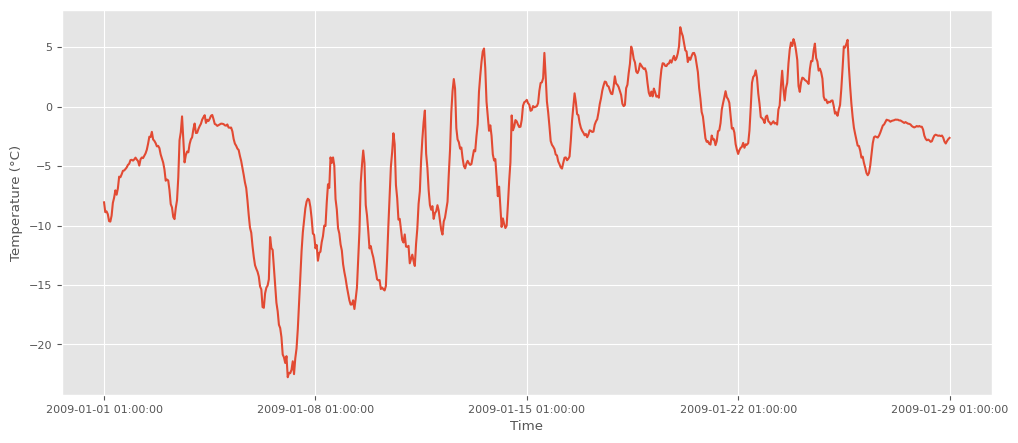

In [4]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

In [5]:
display(load.describe())

count    50224.000000
mean         9.254321
std          8.625312
min        -22.760000
25%          3.140000
50%          9.450000
75%         15.452500
max         35.650000
Name: T (degC), dtype: float64

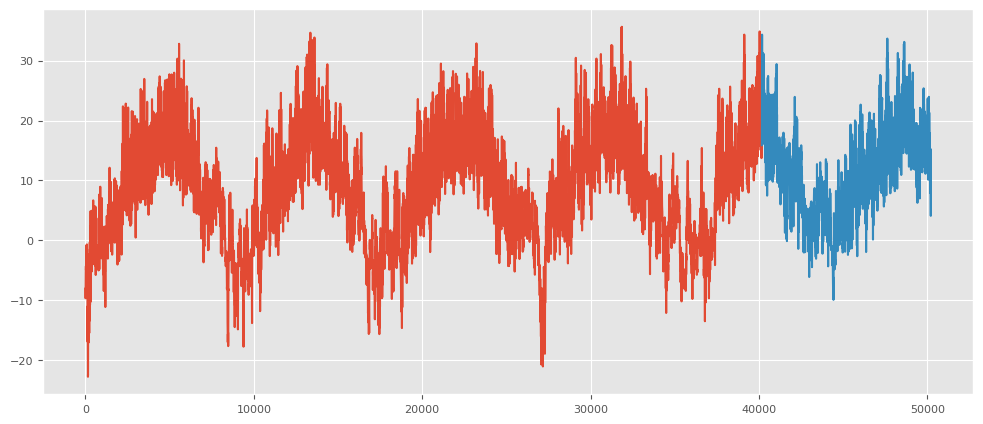

In [6]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]
plt.plot(train)
plt.plot(test)
plt.show()

<Figure size 1200x500 with 0 Axes>

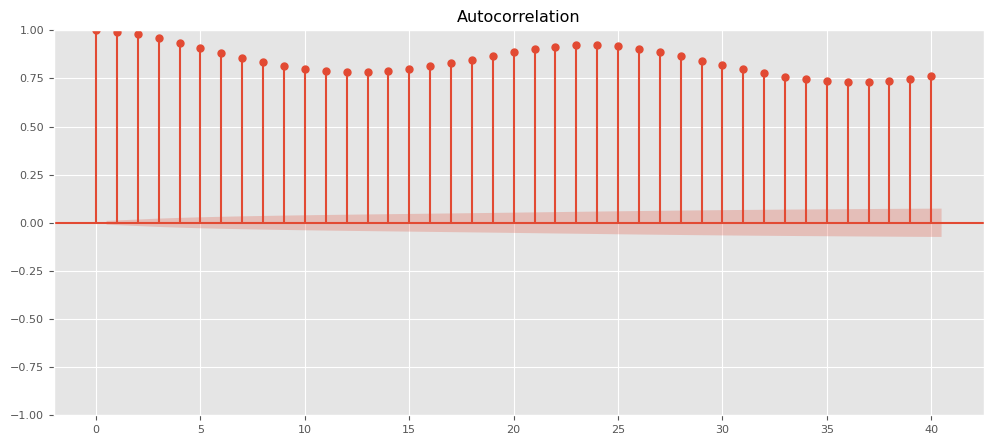

<Figure size 1200x500 with 0 Axes>

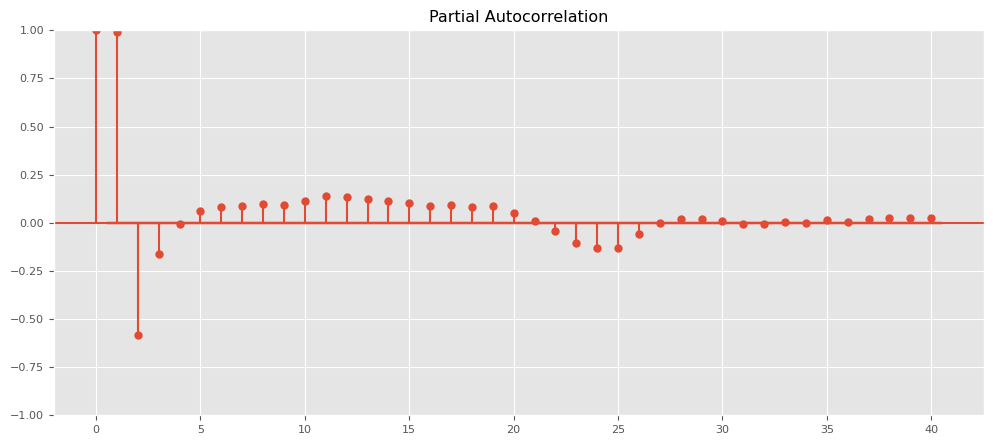

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
acf_values = acf(train)
plot_acf(train, lags=40)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=40)
plt.show()

In [8]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
t_degc = 'T (degC)'

for i in range(1,4):
    df_train["lag{}".format(i)] = df_train[t_degc].shift(i)
    df_test["lag{}".format(i)] = df_test[t_degc].shift(i)

df_train = df_train.bfill()
df_train = df_train.drop(columns = [t_degc])
df_test = df_test.bfill()
df_test = df_test.drop(columns = [t_degc])

display(df_train, df_test)

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# Empirical M Decomposition - SVM¶

In [9]:
!pip install emd


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# EEMD

<Axes: xlabel='Time (samples)'>

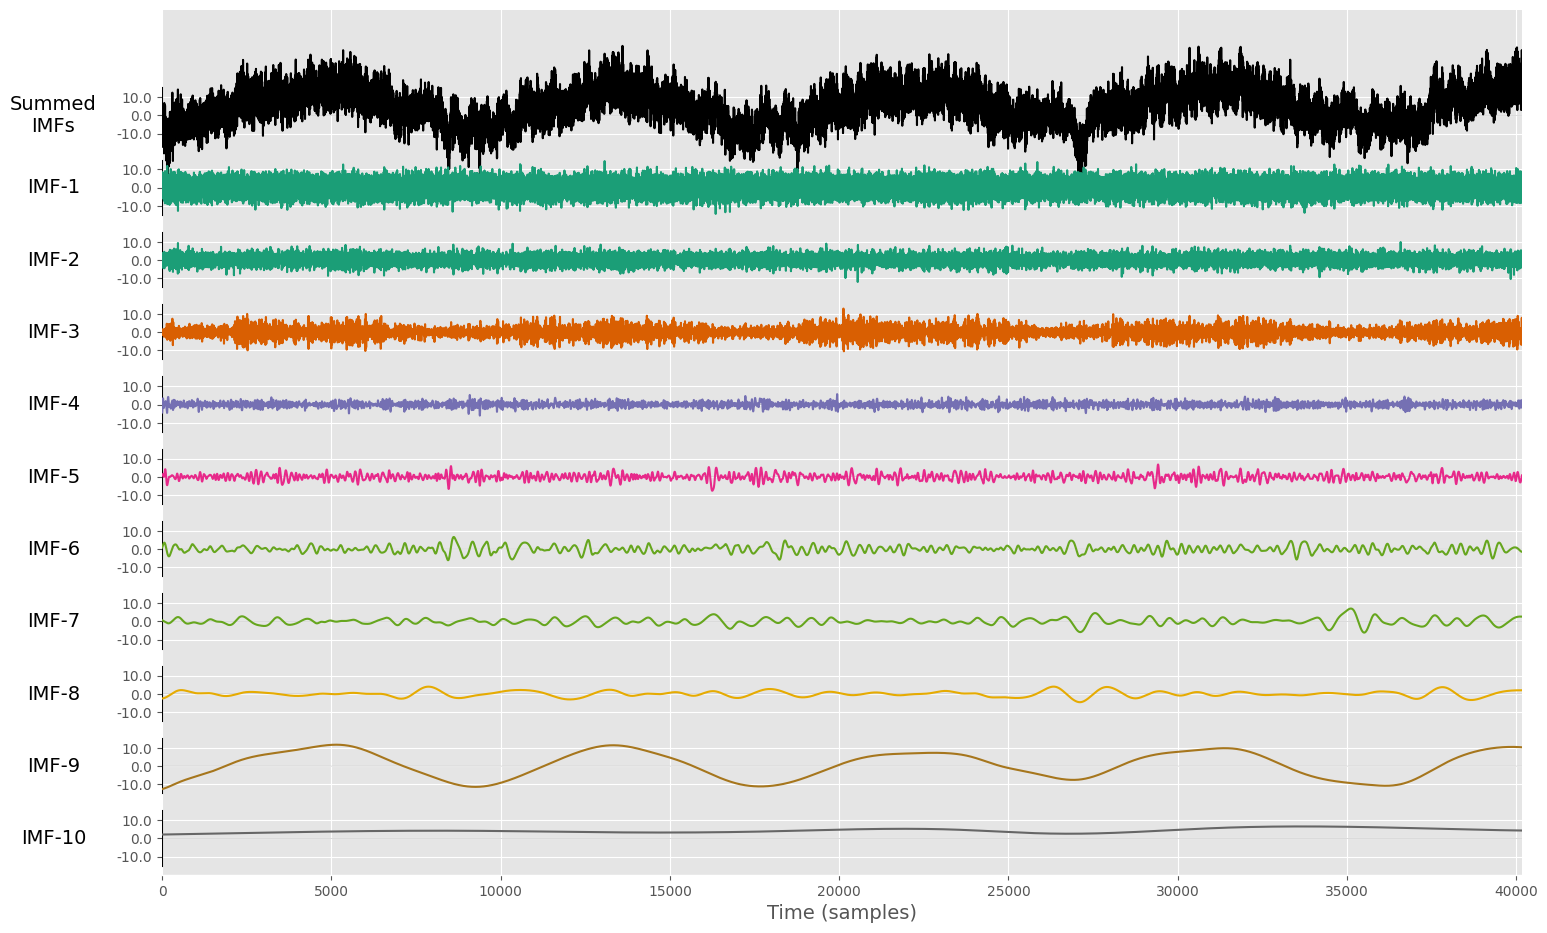

In [10]:
import emd

imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [11]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,6.730994,-0.901160,1.561724,-4.352102,1.080921,0.932684,0.665472,-2.566182,-12.623642,2.132615
1,-4.061242,1.511884,1.216213,-4.217406,1.105328,0.976827,0.655242,-2.564236,-12.618290,2.132918
2,6.315660,2.581186,0.941236,-4.021179,1.133328,1.021852,0.645112,-2.562221,-12.612920,2.133221
3,-3.399315,0.181333,0.751183,-3.767834,1.164107,1.067734,0.635077,-2.560137,-12.607530,2.133525
4,-1.197565,-2.525888,0.605752,-3.463935,1.196938,1.114445,0.625129,-2.557983,-12.602123,2.133828
...,...,...,...,...,...,...,...,...,...,...
40174,4.421167,-2.636332,-2.309499,2.533274,0.990105,-1.452653,2.659427,1.940163,10.323533,4.334405
40175,-0.687193,-3.185335,-3.607874,2.562360,0.994339,-1.454143,2.657635,1.940074,10.322107,4.334153
40176,1.509064,-4.107608,-4.491917,2.558166,0.989122,-1.455234,2.655813,1.939982,10.320677,4.333901
40177,-1.688030,-4.230062,-4.910107,2.519459,0.974666,-1.455926,2.653962,1.939886,10.319242,4.333649


In [12]:
imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

In [13]:
from sklearn.preprocessing import MinMaxScaler

def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(1, len(scaled_data)):
        X.append(scaled_data[i-1:i, 0])
        y.append(scaled_data[i, 0])
        
    return np.array(X), np.array(y), scaler

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [15]:
lstm_1 = 64
dropout = 0.2
lstm_2 = 32
dense_1 = 16
dense_2 = 1

epochs = 20
test_length = len(test)

In [16]:
# IMF 9
imf9_eemd_lstm_X, imf9_eemd_lstm_y, scaler9 = prepare_data(imf_eemd_df['imf_eemd_9'])
imf9_eemd_lstm_X = imf9_eemd_lstm_X.reshape((imf9_eemd_lstm_X.shape[0], 1, imf9_eemd_lstm_X.shape[1]))

model9 = Sequential()
model9.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf9_eemd_lstm_X.shape[1], imf9_eemd_lstm_X.shape[2])))
model9.add(Dropout(dropout))
model9.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model9.add(Dense(dense_1, activation='relu'))
model9.add(Dense(dense_2))
model9.compile(optimizer='adam', loss='mse')
model9.fit(imf9_eemd_lstm_X, imf9_eemd_lstm_y, epochs=epochs, verbose=0)
imf9_eemd_lstm_fc = model9.predict(imf9_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf9_eemd_lstm_fc = scaler9.inverse_transform(imf9_eemd_lstm_fc)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [17]:
from pmdarima import auto_arima

# Preparar los datos
imf10_train = imf_eemd_df['imf_eemd_10'].values

# Definir y ajustar el modelo auto_arima
imf10_eemd_auto_arima = auto_arima(imf10_train, seasonal=False, trace=True)
imf10_eemd_auto_arima_fit = imf10_eemd_auto_arima.fit(imf10_train)

# Predecir con el modelo auto_arima
imf10_test = df_test.values
imf10_eemd_auto_arima_fc = imf10_eemd_auto_arima_fit.predict(n_periods=len(imf10_test))

# Si quieres predecir los valores de entrenamiento también
# imf10_eemd_auto_arima_fc_train = imf10_eemd_auto_arima_fit.predict_in_sample()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-897269.405, Time=33.64 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-885546.312, Time=9.14 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-885604.994, Time=12.60 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-885544.291, Time=13.53 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-917557.201, Time=3.89 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-885602.994, Time=16.17 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 88.989 seconds


In [ ]:
# from statsmodels.tsa.arima.model import ARIMA

# imf10_train = imf_eemd_df['imf_eemd_10'].values
# imf10_eemd_ARIMA = ARIMA(imf10_train, order=(2, 1, 0))
# imf10_eemd_ARIMA_fit = imf10_eemd_ARIMA.fit()
# imf10_test = df_test.values
# imf10_eemd_ARIMA_fc = imf10_eemd_ARIMA_fit.forecast(steps=len(imf10_test))

# # Si quieres predecir los valores de entrenamiento también
# # imf10_eemd_ARIMA_fc_train = imf10_eemd_ARIMA_fit.predict(start=0, end=len(imf10_train)-1)

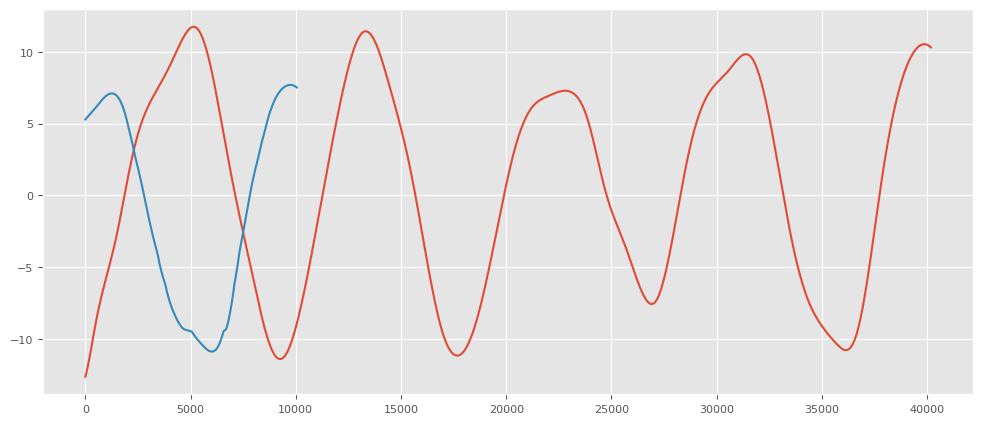

In [18]:
# plot imf10_eemd_SVR_fc real vs predited values
plt.plot(imf_eemd_df['imf_eemd_9'])
plt.plot(imf9_eemd_lstm_fc)
plt.show()

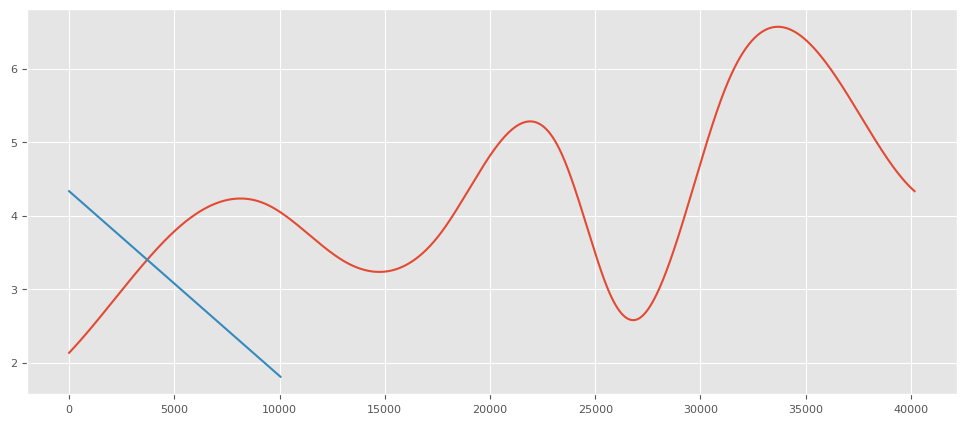

In [19]:
# plot imf10_eemd_SVR_fc real vs predited values
plt.plot(imf_eemd_df['imf_eemd_10'])
plt.plot(imf10_eemd_auto_arima_fc)
plt.show()

In [20]:
imf9_eemd_lstm_fc_9 = imf9_eemd_lstm_fc.reshape(-1)

In [21]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc, imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc, imf8_eemd_SVR_fc, imf9_eemd_lstm_fc_9, imf10_eemd_auto_arima_fc], axis = 0)

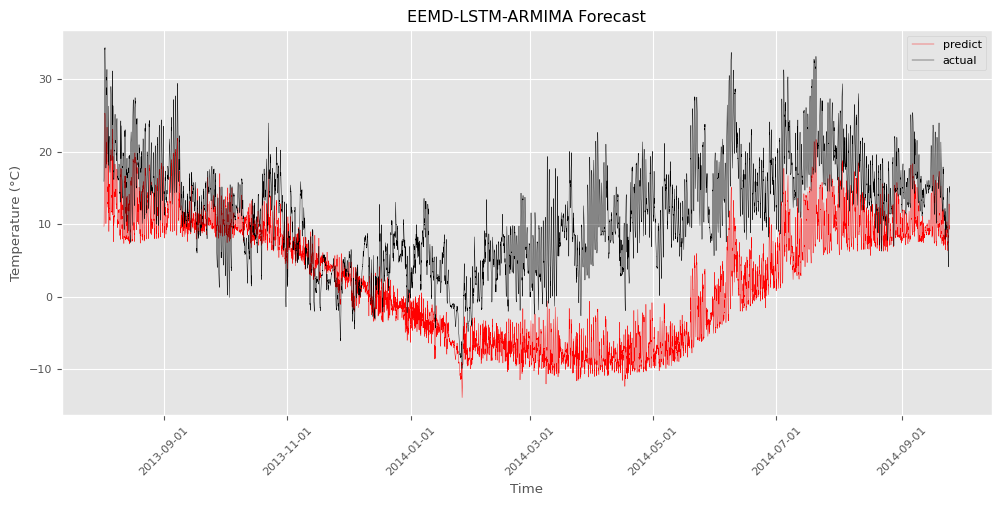

In [22]:
import matplotlib.dates as mdates
import pandas as pd

target_index = 'datetime'
df[target_index] = pd.to_datetime(df[target_index])
df.set_index(target_index, inplace=True)

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc, label='predict', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('EEMD-LSTM-ARMIMA Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

In [23]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 120.66175594293914 
MAE = 9.167592107680722 
MAPE = 7284109222678.573


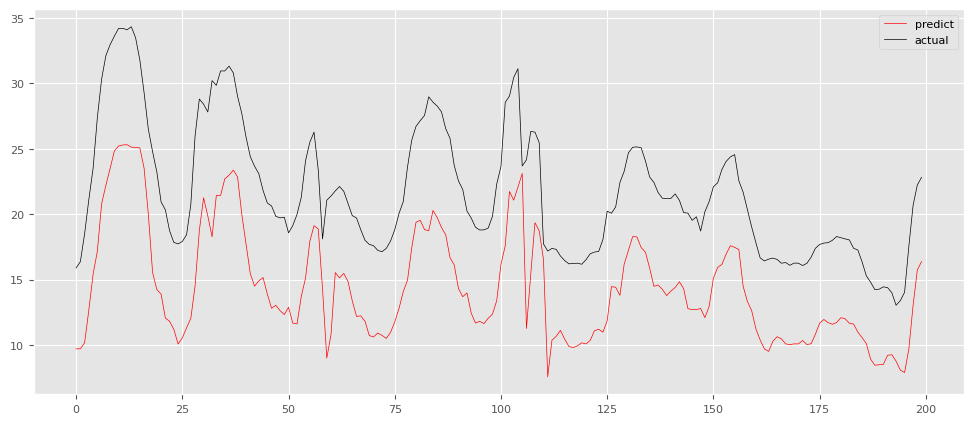

MSE = 120.66175594293914 
MAE = 9.167592107680722 
MAPE = 7284109222678.573


In [24]:
plt.plot(imf_eemd_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [25]:
imf1_eemd_SVR_fc_train = imf1_eemd_SVR.predict(np.array(df_train))
imf2_eemd_SVR_fc_train = imf2_eemd_SVR.predict(np.array(df_train))
imf3_eemd_SVR_fc_train = imf3_eemd_SVR.predict(np.array(df_train))
imf4_eemd_SVR_fc_train = imf4_eemd_SVR.predict(np.array(df_train))
imf5_eemd_SVR_fc_train = imf5_eemd_SVR.predict(np.array(df_train))
imf6_eemd_SVR_fc_train = imf6_eemd_SVR.predict(np.array(df_train))
imf7_eemd_SVR_fc_train = imf7_eemd_SVR.predict(np.array(df_train))
imf8_eemd_SVR_fc_train = imf8_eemd_SVR.predict(np.array(df_train))

In [26]:
imf9_eemd_lstm_fc_train = model9.predict(imf9_eemd_lstm_X).reshape(-1, 1)
imf9_eemd_lstm_fc_train = scaler9.inverse_transform(imf9_eemd_lstm_fc_train)

1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step


In [27]:
imf10_eemd_auto_arima_fc_train = imf10_eemd_auto_arima_fit.predict_in_sample()

In [28]:
#imf10_eemd_ARIMA_fc_train = imf10_eemd_ARIMA_fit.forecast(steps=len(np.array(df_train)))

In [29]:
imf9_eemd_lstm_fc_train = imf9_eemd_lstm_fc_train.reshape(-1)

In [30]:
imf1_eemd_SVR_fc_train.shape

(40179,)

In [31]:
imf9_eemd_lstm_fc_train.shape

(40178,)

In [32]:
# ---------------------
imf10_eemd_auto_arima_fc_train.shape

(40179,)

In [33]:
imf1_eemd_SVR_fc_train_1 = imf1_eemd_SVR_fc_train[1:]
imf2_eemd_SVR_fc_train_2 = imf2_eemd_SVR_fc_train[1:]
imf3_eemd_SVR_fc_train_3 = imf3_eemd_SVR_fc_train[1:]
imf4_eemd_SVR_fc_train_4 = imf4_eemd_SVR_fc_train[1:]
imf5_eemd_SVR_fc_train_5 = imf5_eemd_SVR_fc_train[1:]
imf6_eemd_SVR_fc_train_6 = imf6_eemd_SVR_fc_train[1:]
imf7_eemd_SVR_fc_train_7 = imf7_eemd_SVR_fc_train[1:]
imf8_eemd_SVR_fc_train_8 = imf8_eemd_SVR_fc_train[1:]

imf10_eemd_ARIMA_fc_train_10 = imf10_eemd_auto_arima_fc_train[1:]

In [34]:
imf_eemd_fc_train = np.sum([imf1_eemd_SVR_fc_train_1, imf2_eemd_SVR_fc_train_2, imf3_eemd_SVR_fc_train_3,
                imf4_eemd_SVR_fc_train_4, imf5_eemd_SVR_fc_train_5, imf6_eemd_SVR_fc_train_6,
                imf7_eemd_SVR_fc_train_7, imf8_eemd_SVR_fc_train_8, imf9_eemd_lstm_fc_train, imf10_eemd_ARIMA_fc_train_10], axis = 0)

In [35]:
train = train[1:]

In [36]:
from scipy.optimize import minimize

def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 10.915659
         Iterations: 43
         Function evaluations: 88
[5.74498505]


In [37]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 53.38941650893877 
MAE = 5.637830085970263 
MAPE = 2132668204428.6392


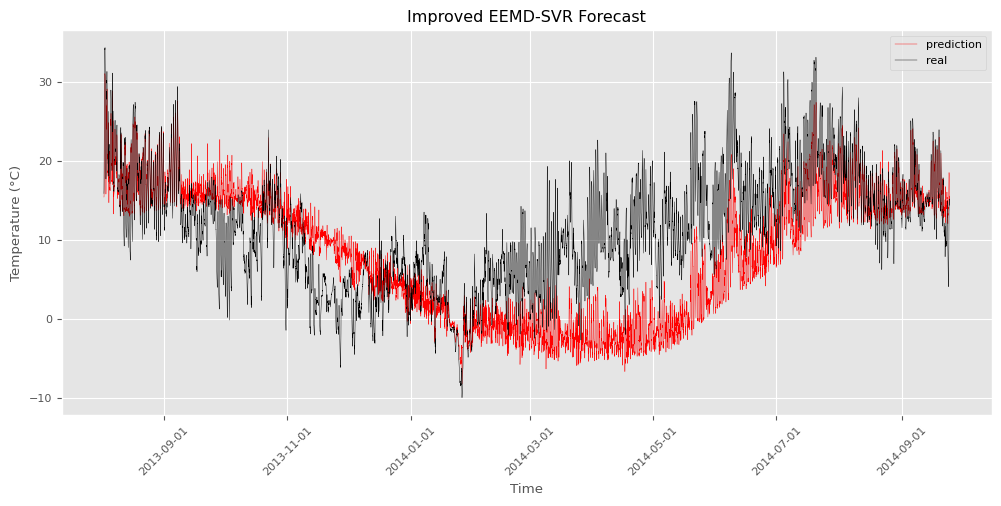

In [38]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc + res1.x[0], label='prediction', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='real', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('Improved EEMD-SVR Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

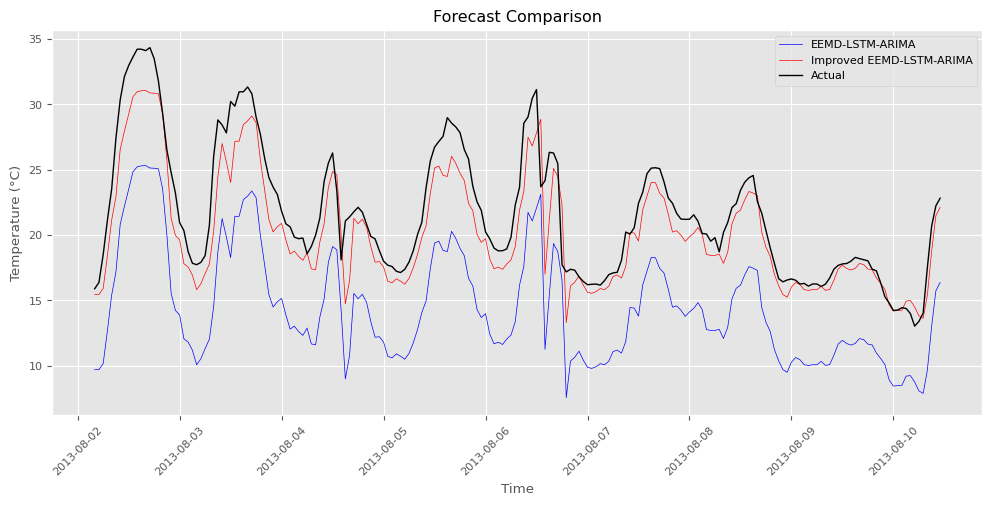

In [39]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

plt.figure(figsize=(12, 5))
plt.plot(test.index[:200], imf_eemd_fc[:200], label='EEMD-LSTM-ARIMA', color='b', linewidth=0.5)
plt.plot(test.index[:200], imf_eemd_fc[:200] + res1.x[0], label='Improved EEMD-LSTM-ARIMA', color='r', linewidth=0.5)
plt.plot(test.index[:200], test.values[:200], label='Actual', color='k', linewidth=1)
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()